In [ ]:
# Install if needed
!pip install pvlib

# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# Load your merged building + PV data
df = pd.read_csv("merged_hourly_with_pv.csv", parse_dates=["timestamp"])
df = df.set_index("timestamp")

# Ensure clean PV data
df["pv_ac_kw"] = df["pv_ac_kw"].clip(lower=0)
df["pv_ac_normalized"] = df["pv_ac_kw"] / df["pv_ac_kw"].max()

print("✅ Loaded merged_hourly_with_pv.csv")
print(df.shape)
df.head()


✅ Loaded merged_hourly_with_pv.csv
(8700, 9)


,raw_MM_Wh,raw_Tenant_Wh,temp_air,dhi,ghi,dni,wind_speed,pv_ac_kw,pv_ac_normalized
timestamp,,,,,,,,,
2023-01-01 00:00:00,31805.17,23168.47,7.4,0,0,0,1.6,0.0,0.0
2023-01-01 01:00:00,27381.22,19302.73,6.7,0,0,0,1.6,0.0,0.0
2023-01-01 02:00:00,25207.58,17440.27,6.4,0,0,0,1.8,0.0,0.0
2023-01-01 03:00:00,23207.99,15739.71,6.0,0,0,0,1.8,0.0,0.0
2023-01-01 04:00:00,21702.68,14349.58,5.9,0,0,0,1.9,0.0,0.0


In [ ]:
# SC9.1 tariff parameters
DELIVERY_CHARGE_PER_KWH = 0.0166
RULE_26_ADJUSTMENTS_PER_KWH = 0.055889
AS_USED_DEMAND_CHARGE_SUMMER = 42.80
AS_USED_DEMAND_CHARGE_NON_SUMMER = 33.50
CUSTOMER_CHARGE = 71.00
BPP_FEE = 1.28
GRT_SURCHARGES_DELIVERY = 0.022195
DELIVERY_SALES_TAX = 0.08775

SUPPLY_CHARGE_PER_KWH = 0.08195
R25_CAPACITY_PER_KW = 8.92
GRT_SURCHARGES_SUPPLY = 0.024066
SUPPLY_SALES_TAX = 0.08775

# Helper
def is_summer_month(month):
    return month in [6, 7, 8]

# Tariff Calculation
def calculate_monthly_bill_sc9i(month, monthly_kwh, monthly_peak_kw):
    # Delivery
    delivery_base = (DELIVERY_CHARGE_PER_KWH + RULE_26_ADJUSTMENTS_PER_KWH) * monthly_kwh
    if is_summer_month(month):
        demand_charge = AS_USED_DEMAND_CHARGE_SUMMER * monthly_peak_kw
    else:
        demand_charge = AS_USED_DEMAND_CHARGE_NON_SUMMER * monthly_peak_kw
    sum_delivery = delivery_base + demand_charge + CUSTOMER_CHARGE + BPP_FEE
    sum_delivery *= (1 + GRT_SURCHARGES_DELIVERY)
    total_delivery = sum_delivery * (1 + DELIVERY_SALES_TAX)

    # Supply
    supply_base = (SUPPLY_CHARGE_PER_KWH * monthly_kwh) + (R25_CAPACITY_PER_KW * monthly_peak_kw)
    supply_base *= (1 + GRT_SURCHARGES_SUPPLY)
    total_supply = supply_base * (1 + SUPPLY_SALES_TAX)

    # Total
    return total_delivery + total_supply


In [ ]:
# Add helper columns
df["month"] = df.index.month
df["year"] = df.index.year

# Calculate Net Load after PV (baseline load - PV generation)
# Assumption: PV offsets the building load first
df["net_load_kw"] = (df["raw_MM_Wh"] / 1000) - df["pv_ac_kw"]
df["net_load_kw"] = df["net_load_kw"].clip(lower=0)  # cannot have negative net load

# Convert net load back to kWh per hour
df["net_load_kwh"] = df["net_load_kw"] * 1  # 1 hour interval


In [ ]:
monthly_summary = []

for (year, month), group in df.groupby(["year", "month"]):
    total_kwh_baseline = group["raw_MM_Wh"].sum() / 1000  # Wh → kWh
    peak_kw_baseline = group["raw_MM_Wh"].max() / 1000    # Wh → kW

    total_kwh_net = group["net_load_kwh"].sum()
    peak_kw_net = group["net_load_kw"].max()

    bill_baseline = calculate_monthly_bill_sc9i(month, total_kwh_baseline, peak_kw_baseline)
    bill_with_pv = calculate_monthly_bill_sc9i(month, total_kwh_net, peak_kw_net)

    monthly_summary.append({
        "year": year,
        "month": month,
        "baseline_bill_usd": bill_baseline,
        "bill_with_pv_usd": bill_with_pv,
        "kwh_baseline": total_kwh_baseline,
        "kwh_net": total_kwh_net,
        "kwh_saved": total_kwh_baseline - total_kwh_net,
        "usd_saved": bill_baseline - bill_with_pv,
    })

# Turn into DataFrame
monthly_bills = pd.DataFrame(monthly_summary)
monthly_bills.to_csv("monthly_bills.csv", index=False)
print("✅ monthly_bills.csv saved")
print("✅ Monthly billing summary ready")
monthly_bills.head()


✅ monthly_bills.csv saved
✅ Monthly billing summary ready


,year,month,baseline_bill_usd,bill_with_pv_usd,kwh_baseline,kwh_net,kwh_saved,usd_saved
0,2023,1,7402.356937,6336.197164,27407.861740,21205.160521,6202.701219,1066.159772
1,2023,2,6766.543978,5487.822568,24211.742708,16772.401012,7439.341696,1278.721410
2,2023,3,6947.315086,5438.091738,25529.962960,16749.607759,8780.355201,1509.223348
3,2023,4,6656.971847,4919.582553,23956.310762,13848.532378,10107.778384,1737.389295
4,2023,5,6931.415753,4878.943643,25332.633740,13391.767472,11940.866268,2052.472110


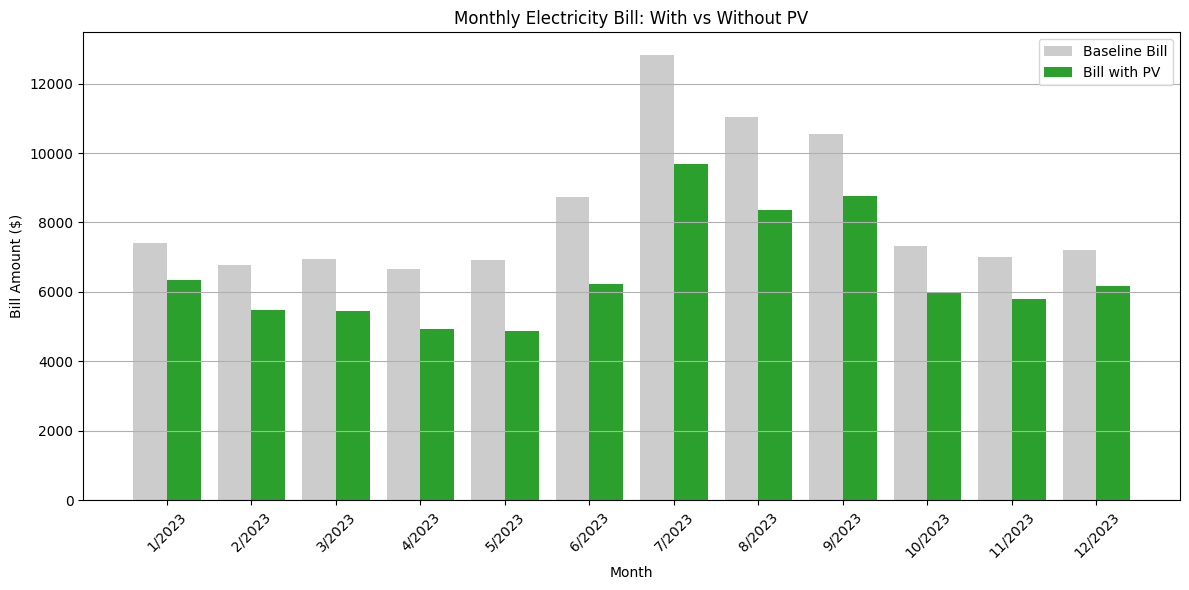

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Bar chart of baseline vs PV bill
plt.bar(
    monthly_bills["month"] + (monthly_bills["year"] - monthly_bills["year"].min()) * 12,
    monthly_bills["baseline_bill_usd"],
    color="#cccccc", label="Baseline Bill", width=0.4
)

plt.bar(
    monthly_bills["month"] + (monthly_bills["year"] - monthly_bills["year"].min()) * 12 + 0.4,
    monthly_bills["bill_with_pv_usd"],
    color="#2ca02c", label="Bill with PV", width=0.4
)

plt.xlabel("Month")
plt.ylabel("Bill Amount ($)")
plt.title("Monthly Electricity Bill: With vs Without PV")
plt.xticks(
    ticks=monthly_bills["month"] + (monthly_bills["year"] - monthly_bills["year"].min()) * 12 + 0.2,
    labels=[f"{m}/{y}" for y, m in zip(monthly_bills["year"], monthly_bills["month"])],
    rotation=45
)
plt.legend()
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


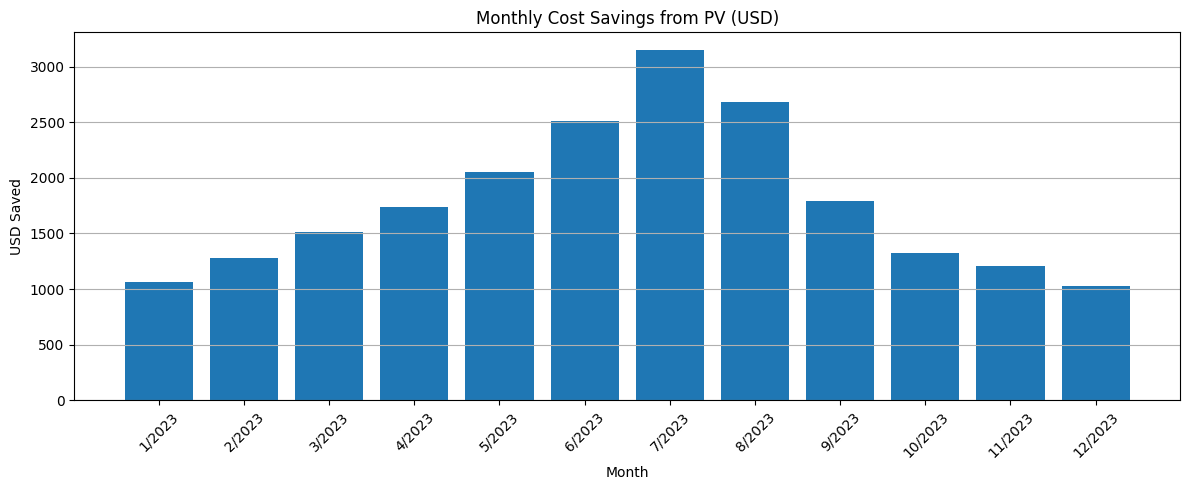

In [ ]:
plt.figure(figsize=(12, 5))
plt.bar(
    monthly_bills["month"] + (monthly_bills["year"] - monthly_bills["year"].min()) * 12,
    monthly_bills["usd_saved"],
    color="#1f77b4"
)

plt.title("Monthly Cost Savings from PV (USD)")
plt.xlabel("Month")
plt.ylabel("USD Saved")
plt.xticks(
    ticks=monthly_bills["month"] + (monthly_bills["year"] - monthly_bills["year"].min()) * 12,
    labels=[f"{m}/{y}" for y, m in zip(monthly_bills["year"], monthly_bills["month"])],
    rotation=45
)
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


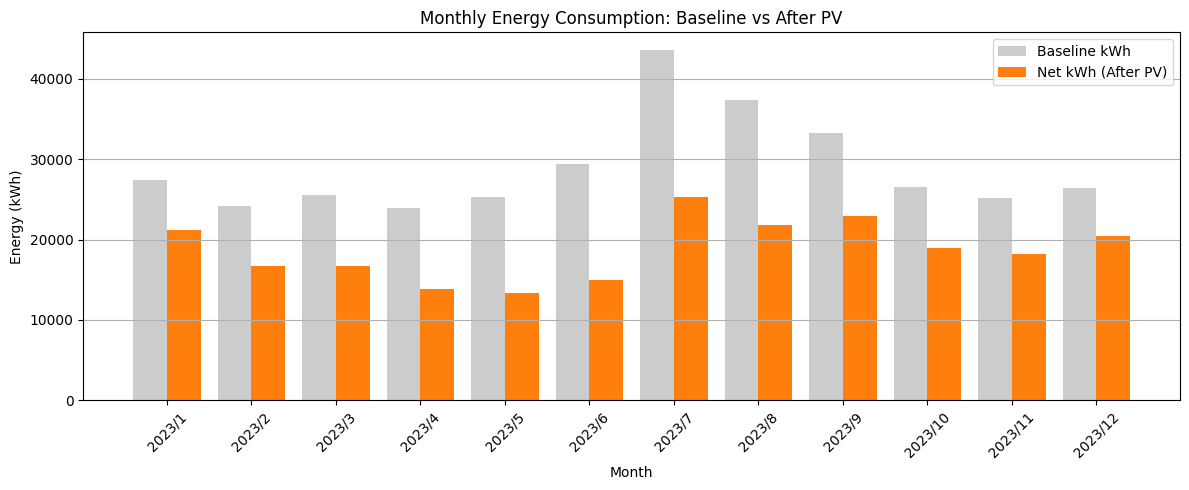

In [ ]:
# Step 1: Monthly Energy Savings Bar Chart

plt.figure(figsize=(12, 5))

month_number = monthly_bills["month"] + (monthly_bills["year"] - monthly_bills["year"].min()) * 12

plt.bar(
    month_number,
    monthly_bills["kwh_baseline"],
    color="#cccccc", label="Baseline kWh", width=0.4
)

plt.bar(
    month_number + 0.4,
    monthly_bills["kwh_net"],
    color="#ff7f0e", label="Net kWh (After PV)", width=0.4
)

plt.xlabel("Month")
plt.ylabel("Energy (kWh)")
plt.title("Monthly Energy Consumption: Baseline vs After PV")
plt.xticks(
    ticks=month_number + 0.2,
    labels=[f"{m}/{y}" for y, m in zip(monthly_bills["month"], monthly_bills["year"])],
    rotation=45
)
plt.legend()
plt.grid(True, axis="y")
plt.tight_layout()
plt.show()


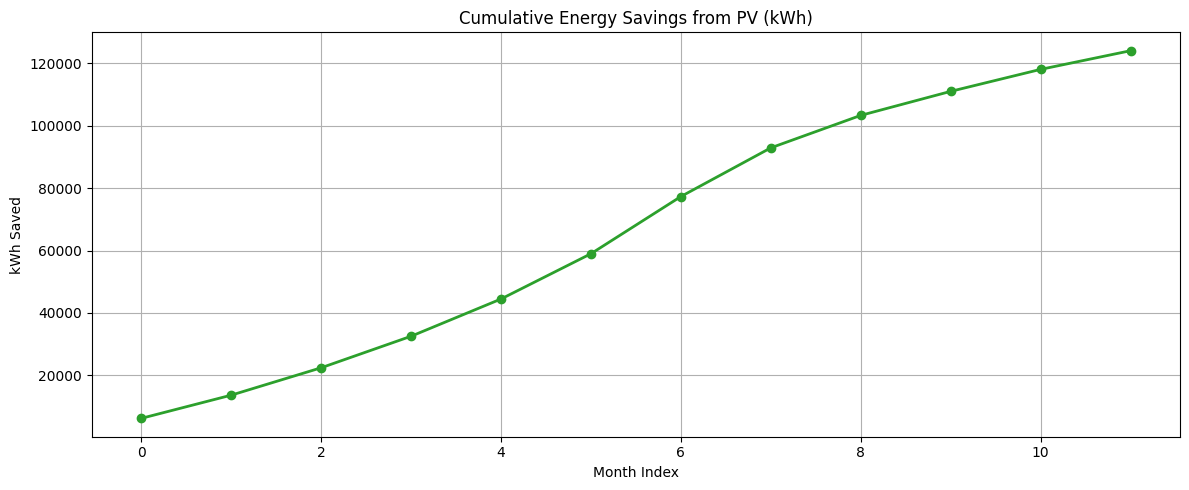

In [ ]:
# Step 2: Cumulative Energy Savings Plot (kWh)

monthly_bills["cumulative_kwh_saved"] = monthly_bills["kwh_saved"].cumsum()

plt.figure(figsize=(12, 5))
plt.plot(
    monthly_bills["cumulative_kwh_saved"],
    marker='o', linewidth=2, color="#2ca02c"
)

plt.title("Cumulative Energy Savings from PV (kWh)")
plt.xlabel("Month Index")
plt.ylabel("kWh Saved")
plt.grid(True)
plt.tight_layout()
plt.show()
